In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-492bd5bb-7e57-b3ec-c3e3-41a522409714)


In [ ]:
import tensorflow as tf

print(tf.__version__)

2.8.0


In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, \
  Conv2D, BatchNormalization, ZeroPadding2D, MaxPooling2D, Activation, add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

IMAGE_SIZE = [224,224]

epochs=16
batch_size=64

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/blood_cell_images.zip

File ‘blood_cell_images.zip’ already there; not retrieving.



In [ ]:
!unzip -nq blood_cell_images.zip

In [ ]:
train_path = '/content/blood_cell_images/TRAIN'
test_path = '/content/blood_cell_images/TEST'

image_files = glob(train_path + '/*/*.jp*g')
test_image_files = glob(test_path + '/*/*.jp*g')

#num classes
folders = glob(train_path + '/*')

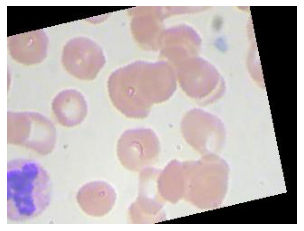

In [ ]:
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.axis(False)
plt.show();

In [ ]:
res = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in res.layers[:-20]:
  layer.trainable=False

for layer in res.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

In [ ]:
for layer in res.layers:
  print(layer.name, layer.trainable)

input_6 False
conv1_pad False
conv1_conv False
conv1_bn True
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn True
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn True
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn True
conv2_block1_3_bn True
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn True
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn True
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn True
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn True
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn True
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn True
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn True
conv3_block1_1_relu False
conv3_block1_2_conv False
conv

In [ ]:
x = Flatten()(res.output)
x = Dense(1000, activation='relu')(x)
output = Dense(len(folders), activation='softmax')(x)

model = Model(inputs=res.input, outputs=output)

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

#get labels
test_gen = val_gen.flow_from_directory(test_path, target_size=IMAGE_SIZE, class_mode='sparse')
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min:  -123.68 max:  151.061


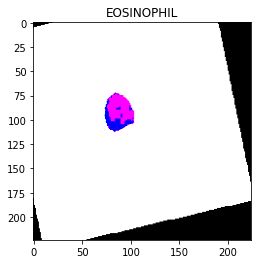

In [ ]:
import cv2

for x, y in test_gen:
  print('min: ', x[0].min(), 'max: ', x[0].max())
  plt.title(labels[np.argmax(y[0])])
  img_rgb = cv2.cvtColor(x[0], cv2.COLOR_BGR2RGB)
  plt.imshow(img_rgb)
  plt.show();
  break

In [ ]:
train_generator = train_gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
    class_mode='sparse',
)

val_generator = val_gen.flow_from_directory(
    test_path, 
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='sparse'
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [ ]:
checkpoint_filepath = '/tmp/checkpoint'

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['accuracy'])

h = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=len(image_files) // batch_size,
    validation_steps=len(test_image_files) // batch_size,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(
                   monitor='loss', patience=3, restore_best_weights=True
               ),
               tf.keras.callbacks.ModelCheckpoint(
                   filepath=checkpoint_filepath,
                   save_weights_only=True,
                   monitor='val_accuracy',
                   mode='max',
                   save_best_only=True
               ),
    ]
)

Epoch 1/16
155/155 [==============================] - 218s 1s/step - loss: 0.9630 - accuracy: 0.7512 - val_loss: 1.0049 - val_accuracy: 0.7253
Epoch 2/16
155/155 [==============================] - 206s 1s/step - loss: 0.1484 - accuracy: 0.9426 - val_loss: 0.7488 - val_accuracy: 0.8158
Epoch 3/16
155/155 [==============================] - 205s 1s/step - loss: 0.0708 - accuracy: 0.9737 - val_loss: 0.9751 - val_accuracy: 0.8359
Epoch 4/16
155/155 [==============================] - 202s 1s/step - loss: 0.0461 - accuracy: 0.9844 - val_loss: 1.1495 - val_accuracy: 0.7911
Epoch 5/16
155/155 [==============================] - 204s 1s/step - loss: 0.0449 - accuracy: 0.9839 - val_loss: 1.2197 - val_accuracy: 0.8178
Epoch 6/16
155/155 [==============================] - 193s 1s/step - loss: 0.0531 - accuracy: 0.9820 - val_loss: 2.0818 - val_accuracy: 0.7225
Epoch 7/16
155/155 [==============================] - 196s 1s/step - loss: 0.0225 - accuracy: 0.9923 - val_loss: 1.1562 - val_accuracy: 0.8318

## Recreating resnet architeture

In [ ]:
def identity_block(input_, kernel_size, filters):
  f1, f2, f3 = filters
  
  x = Conv2D(f1, (1,1), kernel_initializer='he_normal')(input_)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(f2, kernel_size, padding='same', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(f3, (1,1), kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)

  x = add([x, input_])
  x = Activation('relu')(x)

  return x

In [ ]:
def conv_block(input_, kernel_size, filters, strides=(2,2)):
  f1, f2, f3 = filters

  x = Conv2D(f1, (1,1), strides=strides, kernel_initializer='he_normal')(input_)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(f2, kernel_size, padding='same', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(f3, (1,1), kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  
  shortcut = Conv2D(f3, (1,1), strides=strides, kernel_initializer='he_normal')(input_)
  shortcut = BatchNormalization()(shortcut)

  x = add([x, shortcut])
  x = Activation('relu')(x)

  return x

In [ ]:
i = Input(shape=IMAGE_SIZE + [3])
x = ZeroPadding2D(padding=(3,3))(i)
x = Conv2D(64, (7,7), strides=(2,2), padding='valid',
           kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1,1))(x)
x = MaxPooling2D((3,3), strides=(2,2))(x)

x = conv_block(x, 3, [64, 64, 256], strides=(1,1))
x = identity_block(x, 3, [64, 64, 256])
x = identity_block(x, 3, [64, 64, 256])

x = conv_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])

x = Flatten()(x)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

model_custom = Model(inputs=i, outputs=prediction) 

model_custom.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_7[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_48 (Conv2D)             (None, 112, 112, 64  9472        ['zero_padding2d_4[0][0]']       
                                )                                                           

In [ ]:
model_custom.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

def preprocess_input2(x):
  x /= 127.5
  x -= 1.
  return x

train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input2
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input2
)

In [ ]:
#get labels
test_gen = val_gen.flow_from_directory(test_path, target_size=IMAGE_SIZE, class_mode='sparse')
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


min:  -1.0 max:  1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


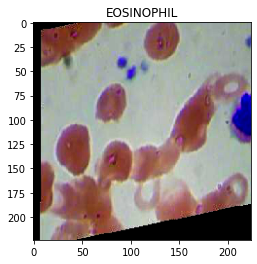

In [ ]:
for x, y in test_gen:
  print('min: ', x[0].min(), 'max: ', x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [ ]:
train_generator = train_gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
    class_mode='sparse'
)

valid_generator = val_gen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
    class_mode='sparse'
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [ ]:
checkpoint_filepath = '/tmp/checkpoint2'

h_custom = model_custom.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    steps_per_epoch=len(image_files) // batch_size,
    validation_steps=len(test_image_files) // batch_size,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(
                   monitor='loss', patience=3, restore_best_weights=True
               ),
               tf.keras.callbacks.ModelCheckpoint(
                   filepath=checkpoint_filepath,
                   save_weights_only=True,
                   monitor='val_accuracy',
                   mode='max',
                   save_best_only=True
               ),
    ]
)

Epoch 1/16
155/155 [==============================] - 182s 1s/step - loss: 6.6374 - accuracy: 0.3044 - val_loss: 3.7838 - val_accuracy: 0.3281
Epoch 2/16
155/155 [==============================] - 185s 1s/step - loss: 2.5694 - accuracy: 0.5590 - val_loss: 1.4803 - val_accuracy: 0.6069
Epoch 3/16
155/155 [==============================] - 184s 1s/step - loss: 1.0395 - accuracy: 0.7684 - val_loss: 2.6312 - val_accuracy: 0.6665
Epoch 4/16
155/155 [==============================] - 177s 1s/step - loss: 0.7742 - accuracy: 0.8470 - val_loss: 1.8930 - val_accuracy: 0.7282
Epoch 5/16
155/155 [==============================] - 174s 1s/step - loss: 0.9498 - accuracy: 0.8666 - val_loss: 1.3271 - val_accuracy: 0.8610
Epoch 6/16
155/155 [==============================] - 173s 1s/step - loss: 0.6480 - accuracy: 0.9098 - val_loss: 3.1723 - val_accuracy: 0.7266
Epoch 7/16
155/155 [==============================] - 175s 1s/step - loss: 0.5766 - accuracy: 0.9181 - val_loss: 2.3455 - val_accuracy: 0.7821

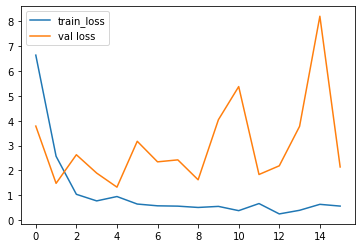

In [ ]:
plt.plot(h_custom.history['loss'], label='train_loss')
plt.plot(h_custom.history['val_loss'], label='val loss')
plt.legend()
plt.show();

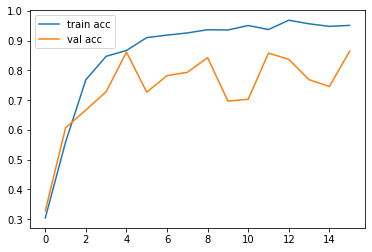

In [ ]:
plt.plot(h_custom.history['accuracy'], label='train acc')
plt.plot(h_custom.history['val_accuracy'], label='val acc')
plt.legend()
plt.show();

In [ ]:
model.load_weights('/tmp/checkpoint')
model_custom.load_weights(checkpoint_filepath)

In [ ]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(data_path, N, model):
  print('Generating confusion matrix', N)

  predictions = []
  targets = []
  i = 0

  for x, y in val_gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size*2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))

    if len(targets) >= N:
      break
    
  cm = confusion_matrix(targets, predictions)
  return cm

In [ ]:
valid_cm = get_confusion_matrix(test_path, len(test_image_files), model)
valid_cm_custom = get_confusion_matrix(test_path, len(test_image_files), model_custom)

Generating confusion matrix 2487
Found 2487 images belonging to 4 classes.
Generating confusion matrix 2487
Found 2487 images belonging to 4 classes.


In [ ]:
print(valid_cm_custom)

[[492   0   3 128]
 [  1 591  28   0]
 [  0   0 475 145]
 [ 98   0   1 525]]


In [ ]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center',
             color='white' if cm[i, j] >  thresh else 'black')
    
  plt.tight_layout()
  plt.xlabel('True label')
  plt.ylabel('Predicted label')
  plt.show();

Confusion matrix, without normalization


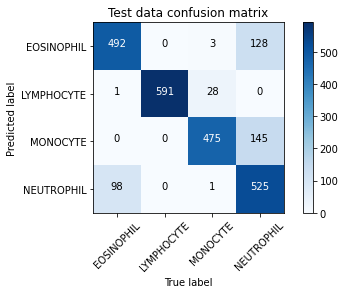

In [ ]:
plot_confusion_matrix(valid_cm_custom, labels, title='Test data confusion matrix')